# Forecasting Demo 1: Prophet and NeuralProphet

This notebook is the first of a series that introduces the application of popular, recently developed time series forecasting methods. In particular, we emphasize the use of consistent evaluation metrics and analysis across all models and model configurations. 

Use these notebooks as tools to explore the application of various forecasting methods to multivariate time series datasets, and to inspire an experimental approach for comparing multiple models and model configurations.

This notebook explores the application of **Prophet** and **NeuralProphet** to exchange rate forecasting.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install prophet
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from neuralprophet import NeuralProphet

Importing plotly failed. Interactive plots will not work.


# Data Loading

### Load exchange rate data file

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
# data_filename = "/h/ethanj/bootcamp_datasets/exchange_rate/exchange_rate.csv"
data_filename = "/Volumes/GoogleDrive/My Drive/Forecasting/bootcamp_datasets/boc_exchange/dataset.csv"
# data_filename = "/content/drive/MyDrive/bootcamp_datasets/exchange_rate/exchange_rate.csv"
data_df = pd.read_csv(data_filename, index_col=0)
data_df.index = pd.to_datetime(data_df.index)
data_df = data_df.reset_index().rename({'index':'date'}, axis=1)
data_df

,date,AUD_CLOSE,DKK_CLOSE,EUR_CLOSE,HKD_CLOSE,JPY_CLOSE,MXN_CLOSE,NZD_CLOSE,NOK_CLOSE,SEK_CLOSE,CHF_CLOSE,GBP_CLOSE,USD_CLOSE
0,2007-05-01,0.9200,0.2000,1.5100,0.141970,0.009271,0.10000,0.8200,0.1860,0.1700,0.9100,2.2199,1.1105
1,2007-05-02,0.9100,0.2000,1.5100,0.141740,0.009232,0.10000,0.8200,0.1854,0.1700,0.9100,2.2055,1.1087
2,2007-05-03,0.9100,0.2000,1.5000,0.141496,0.009190,0.10000,0.8100,0.1847,0.1600,0.9100,2.1999,1.1066
3,2007-05-04,0.9100,0.2000,1.5100,0.141616,0.009218,0.10000,0.8100,0.1854,0.1600,0.9100,2.2075,1.1075
4,2007-05-05,0.9100,0.2000,1.5100,0.141616,0.009218,0.10000,0.8100,0.1854,0.1600,0.9100,2.2075,1.1075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,2017-04-24,1.0218,0.1974,1.4684,0.173684,0.012310,0.07215,0.9477,0.1579,0.1525,1.3568,1.7280,1.3511
3647,2017-04-25,1.0224,0.1994,1.4837,0.174374,0.012210,0.07183,0.9426,0.1586,0.1548,1.3661,1.7407,1.3565
3648,2017-04-26,1.0176,0.1995,1.4847,0.174965,0.012260,0.07098,0.9382,0.1585,0.1554,1.3707,1.7493,1.3612
3649,2017-04-27,1.0176,0.1992,1.4815,0.175103,0.012250,0.07151,0.9369,0.1590,0.1543,1.3704,1.7584,1.3624


### Split data according to use case

For simplicity, this notebook uses only one validation period consisting of the last `lead_time` rows in the dataset. Other notebooks give examples of rolling cross validation using multiple validation periods given by a set of cutoff dates. 

The purpose of this notebook is to explore a simpler problem formulation using multiple models. The experiments and analysis can be easily generalized for rolling cross validation.

In [34]:
lag_time = 60
lead_time = 30

train_size = 0.8

train_df = data_df.iloc[:int(len(data_df)*train_size)]
test_df = data_df.iloc[int(len(data_df)*train_size):]

# prophet_train_df = data_df.iloc[:-lead_time] 
# prophet_test_df = data_df.iloc[-lead_time:]

# train_df = data_df.iloc[:-lag_time-lead_time]
# test_df = data_df.iloc[-lag_time-lead_time:]
# test_eval_df = test_df.iloc[-lead_time:]

To run inference on a single test example, we need to withhold at least `lag_time + lead_time` observations from the data set. Assuming we want to test a fitted model on all available examples in the test set, the number of testing examples can be computed as follows.

In [26]:
n_test_cases = len(test_df) - lag_time - lead_time
print(f"Number of test examples: {n_test_cases}")

Number of test examples: 641


### Iterating over test examples

To help with iterating over test examples, we define a PyTorch-like dataset class so that we can conveniently and cleanly index examples of input/output pairs according to the specified `lag_time` and `lead_time`.

In [60]:
class ForecastingDataset:

    def __init__(self, data_df, lag_time, lead_time, feature_columns):
        self.n_examples = len(data_df) - lag_time - lead_time
        assert self.n_examples >= 0, "Dataset must contain at least one example."
        assert "date" in data_df.columns or "ds" in data_df.columns, "Source DataFrame must contain a date/ds column."

        self.df = data_df[feature_columns]
        if 'date' in data_df.columns:
            self.dates = data_df.date
        elif 'ds' in data_df.columns:
            self.dates = data_df.ds
        self.lag_time = lag_time
        self.lead_time = lead_time

    def __len__(self):
        return self.n_examples

    def __getitem__(self, idx):
        input = self.df.iloc[idx:idx+lag_time]
        output = self.df.iloc[idx+lag_time:idx+lag_time+lead_time]
        input_dates = self.dates[idx:idx+lag_time]
        output_dates = self.dates[idx+lag_time:idx+lag_time+lead_time]
        return input, output, input_dates, output_dates

In [81]:
feature_columns = [col for col in test_df if col.endswith("_CLOSE")]
test_dataset = ForecastingDataset(test_df, lag_time, lead_time, feature_columns)

# Prophet

Univariate forecasting that supports additional *future* regressors. Prophet does not support the inclusion of *lagged regressors*, i.e. it does not support the use of historical values of multiple series to predict a single target series. We include it as a baseline because it is popular, lightweight, interpretable, and performs very well in some domains. 

Prophet is based on a Generalized Additive Model (GAM):

$ y(t) = g(t) + s(t) + h(t) + \epsilon_t$

where $y(t)$ is the target series, $g(t)$ is the trend function, $s(t)$ is the seasonality or periodic function, $h(t)$ is a function reflecting holidays or other irregular events, and $\epsilon_t$ is an error term that is assumed to be normally distributed.

Despite being formulated as an additive model, multiplicative interaction between seasonality and trend components is supported (using a log transform). In the implementation, this is easily configurable using a constructor paramter. See the [documentation](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) for more details.

#### Data Preparation

Prophet, like most forecasting packages, imposes its own, specific format for input data. It expects inputs in the form of a Pandas DataFrame with two columns, `ds` and `y`, which correspond to Pandas-formatted timestamps and the target time series, respectively.

In this example, we create a Prophet DataFrame by selecting the columns `date` and `OT` from the exchange rate dataset (the name `OT` stands for "Our Target" as described in the [Autoformer paper](https://arxiv.org/abs/2106.13008)'s benchmark datasets). We then rename those columns to `ds` and `y`, respectively. 

Note that the `ds` column is already correctly formatted using the Pandas datetime format, since we converted it immediately after loading the data. When reading CSVs, always be sure to check that datestamps are properly formatted.

In [35]:
prophet_model_df = train_df[['date', 'USD_CLOSE']]
prophet_model_df = train_df.rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1)
prophet_model_df

,ds,AUD_CLOSE,DKK_CLOSE,EUR_CLOSE,HKD_CLOSE,JPY_CLOSE,MXN_CLOSE,NZD_CLOSE,NOK_CLOSE,SEK_CLOSE,CHF_CLOSE,GBP_CLOSE,y
0,2007-05-01,0.9200,0.2000,1.5100,0.141970,0.009271,0.10000,0.8200,0.1860,0.1700,0.9100,2.2199,1.1105
1,2007-05-02,0.9100,0.2000,1.5100,0.141740,0.009232,0.10000,0.8200,0.1854,0.1700,0.9100,2.2055,1.1087
2,2007-05-03,0.9100,0.2000,1.5000,0.141496,0.009190,0.10000,0.8100,0.1847,0.1600,0.9100,2.1999,1.1066
3,2007-05-04,0.9100,0.2000,1.5100,0.141616,0.009218,0.10000,0.8100,0.1854,0.1600,0.9100,2.2075,1.1075
4,2007-05-05,0.9100,0.2000,1.5100,0.141616,0.009218,0.10000,0.8100,0.1854,0.1600,0.9100,2.2075,1.1075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2015-04-24,0.9524,0.1773,1.3226,0.157028,0.010240,0.07916,0.9250,0.1564,0.1409,1.2761,1.8473,1.2170
2916,2015-04-25,0.9524,0.1773,1.3226,0.157028,0.010240,0.07916,0.9250,0.1564,0.1409,1.2761,1.8473,1.2170
2917,2015-04-26,0.9524,0.1773,1.3226,0.157028,0.010240,0.07916,0.9250,0.1564,0.1409,1.2761,1.8473,1.2170
2918,2015-04-27,0.9500,0.1766,1.3177,0.156142,0.010160,0.07882,0.9249,0.1567,0.1408,1.2655,1.8426,1.2101


#### Model Initialization

In [36]:
model = Prophet()
model = model.fit(prophet_model_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Produce Forecasts

To produce a forecast using a fitted Prophet model, you need to pass it a dataframe with the desired timestamps in a column named `ds`. In the example below, we use the fitted model object to produce a dataframe `future` with dates that extend `lag_time` days beyond the training dates. Passing `future` to the fitted model's `predict` function will return a dataframe populated with a detailed forecast, including model component values and confidence ranges. 

In [37]:
future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

In [38]:
forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3646,2017-04-24,1.422376,0.505548,2.395865,0.512460,2.392531,0.001785,0.001785,0.001785,7.251650e-07,7.251650e-07,7.251650e-07,0.001784,0.001784,0.001784,0.0,0.0,0.0,1.424160
3647,2017-04-25,1.422672,0.508417,2.390410,0.509773,2.394697,0.000846,0.000846,0.000846,-7.142097e-05,-7.142097e-05,-7.142097e-05,0.000918,0.000918,0.000918,0.0,0.0,0.0,1.423519
3648,2017-04-26,1.422969,0.496111,2.387652,0.507852,2.396863,-0.000088,-0.000088,-0.000088,-1.817842e-04,-1.817842e-04,-1.817842e-04,0.000094,0.000094,0.000094,0.0,0.0,0.0,1.422881
3649,2017-04-27,1.423265,0.508288,2.399094,0.506021,2.399030,-0.000903,-0.000903,-0.000903,-2.216144e-04,-2.216144e-04,-2.216144e-04,-0.000681,-0.000681,-0.000681,0.0,0.0,0.0,1.422362
3650,2017-04-28,1.423561,0.503612,2.396546,0.502375,2.401196,-0.001214,-0.001214,-0.001214,1.882022e-04,1.882022e-04,1.882022e-04,-0.001402,-0.001402,-0.001402,0.0,0.0,0.0,1.422347


### Plotting Prophet Forecasts

The following code visualizes the application of the fitted Prophet model to both in-sample (training) and out-of-sample (testing) data. Visualization and evaluation of forecasting models using out-of-sample data is crucial for estimating future performance. Notice again that here we are only considering **one** period for out-of-sample performance visualization. Rolling cross validation, where many sequential periods are used for out-of-sample evaluation, is considered in another notebook.

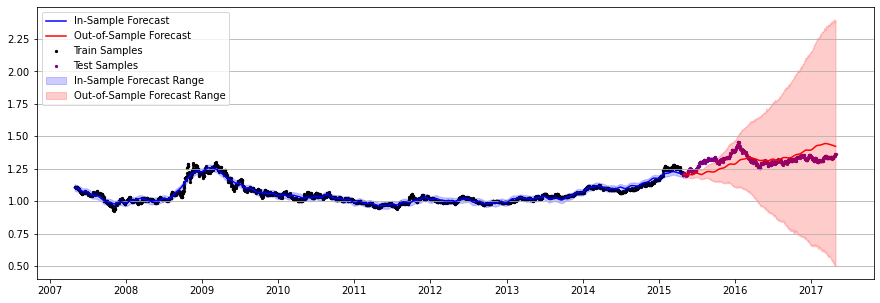

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.scatter(prophet_model_df.ds, prophet_model_df['y'], color='black', s=5, label='Train Samples')
ax.scatter(test_df.date, test_df['USD_CLOSE'], color='purple', s=5, label='Test Samples')

ax.plot(forecast.ds.iloc[:-len(test_df)], 
        forecast.yhat.iloc[:-len(test_df)], color='blue', label='In-Sample Forecast')

ax.fill_between(forecast.ds.iloc[:-len(test_df)], 
    forecast.yhat_lower.iloc[:-len(test_df)], 
    forecast.yhat_upper.iloc[:-len(test_df)],
    color='blue', label='In-Sample Forecast Range', alpha=0.2)

ax.plot(forecast.ds.iloc[-len(test_df):], forecast.yhat.iloc[-len(test_df):], 
        color='red', label='Out-of-Sample Forecast')

ax.fill_between(forecast.ds.iloc[-len(test_df):], 
    forecast.yhat_lower.iloc[-len(test_df):], 
    forecast.yhat_upper.iloc[-len(test_df):],
    color='red', label='Out-of-Sample Forecast Range', alpha=0.2)

ax.legend(loc='upper left')
ax.grid(axis='y')

### Collecting individual forecasts

Split single forecast into a collection of forecasts with `lead_time` predictions each.

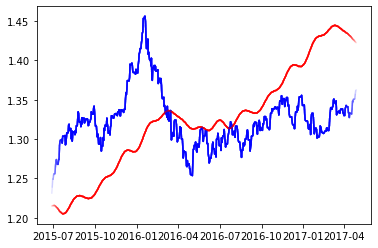

In [65]:
forecast_eval_dataset = ForecastingDataset(forecast.iloc[-len(test_df):], lag_time, lead_time, ['yhat'])

fig, ax = plt.subplots()

for i in range(len(forecast_eval_dataset)):
    x, y, x_d, y_d = forecast_eval_dataset[i]
    x_gt, y_gt, x_gt_d, y_gt_d = test_dataset[i]
    ax.plot(y_d, y, alpha=0.1, color='red')
    ax.plot(y_gt_d, y_gt['USD_CLOSE'], alpha=0.1, color='blue')
    

### Evaluation Metrics

In order to objectively compare the performance of this and other models on out-of-sample forecasting performance, we will need to collect output in a consistent format and apply a suite of standard evaluation metrics:

- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)

See the article [Time Series Forecast Error Metrics You Should Know](https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27) for an overview of these and other popular forecasting error metrics. 


In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = {
    'mse': mean_squared_error,
    'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error
}

In [96]:
def compute_error_metrics(ground_truth_dataset, forecast_dataset):
        
    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecast_dataset)):
        x, y, x_d, y_d = forecast_dataset[i]
        x_gt, y_gt, x_gt_d, y_gt_d = ground_truth_dataset[i]
        for metric_name, metric_fn in metrics.items(): 
            errors[metric_name].append(metric_fn(y_true=y_gt['USD_CLOSE'], y_pred=y))
    
    return errors

error_metrics = compute_error_metrics(test_dataset, forecast_eval_dataset)

In [156]:
prophet_mean_metrics = pd.DataFrame(error_metrics).mean(axis=0).rename('prophet_mean_metrics')
prophet_std_metrics = pd.DataFrame(error_metrics).std(axis=0).rename('prophet_std_metrics')
prophet_max_metrics = pd.DataFrame(error_metrics).max(axis=0).rename('prophet_max_metrics')

prophet_mean_metrics

mse     0.004989
rmse    0.062002
mae     0.060038
mape    0.045071
Name: prophet_mean_metrics, dtype: float64

Before applying these metrics, we will start to collect the out-of-sample forecasts produced by the Prophet model together with the ground truth time series. We aim to do this so that it will be easy to incorporate forecasts produced by (possibly many) other models or model configurations. Be sure to use a naming scheme for columns that is easy to parse.

Note that in the code below we are collecting the forecast ranges (`yhat_lower` and `yhat_upper`) but not using them directly in this evaluation. Since we may want to examine these ranges in other analyses, we will collect them into `results_df` here and save them to file later.

Now that we have collected the out-of-sample Prophet forecast and ground truth time series into `results_df`, we iteratively apply the evaluation metrics and collect the results.

Now that we have collected baseline evaluation metrics for the Prophet model aplied to our out-of-sample data, we can begin to experiment with other configurations or models. Next, let's explore the NeuralProphet model.

# NeuralProphet

Let's proceed to explore the [NeuralProphet](https://neuralprophet.com/html/index.html) model. Please review the following resources to learn more:

- [Paper](https://arxiv.org/abs/2111.15397)
- [Documentation](https://neuralprophet.com/html/contents.html)
- [GitHub](https://github.com/ourownstory/neural_prophet)

In the words of its developers, NeuralProphet is "*based on neural networks, inspired by Facebook Prophet and AR-Net, built on PyTorch*". A very important differentiating feature is that NeuralProphet conveniently supports *lagged regressors*. In the context of this running example, NeuralProphet supports the use of multiple other currencies' time series. With this expanded flexibility, however, the model is more complex, with a greater number of design choices and hyperparameters to consider. 

The official [documentation on lagged regressors (lagged covariates)](https://neuralprophet.com/html/lagged_covariates_energy_ercot.html) gives several examples for configuring NeuralProphet models to use lagged regressors, but commentary and suggestions on best practices are largely absent. 

In the following code, we will consider a small number of NeuralProphet model configurations applied to the same forecasting task from above. Importantly, we retain the same train/test (in-sample/out-of-sample) split, and we will apply the same evaluation metrics to NeuralProphet's forecasts. 

### Baseline/Default Model

A baseline NeuralProphet model with lagged regressors using default initialization parameters, except:

- `n_lags=lag_time`, specifying that the autoregressive component of the model should use the past `lag_time` daily observations as inputs
- `n_forecasts=lead_time`, specifying that our use case is to predict the target signal `lead_time` days into the future

In [114]:
np_train_df = train_df.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)
np_test_df = test_df.reset_index().rename({'date':'ds','USD_CLOSE':'y'}, axis=1).drop('index', axis=1)

In [115]:
np_model = NeuralProphet(n_lags=lag_time, n_forecasts=lead_time)

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('USD_CLOSE', 'ds', 'y')]
for feature in feature_cols:
    np_model.add_lagged_regressor(f'{feature}')
    
np_model.fit(np_train_df, freq='D')

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 138
INFO:NP.config:Auto-set epochs to 138
 82%|████████▏ | 222/272 [00:04<00:00, 52.11it/s]
INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.12E-04, min: 4.42E-02
INFO:NP.utils_torch:lr-range-test results: steep: 7.12E-04, min: 4.42E-02
 82%|████████▏ | 224/272 [00:04<00:00, 49.99it/s]
INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.59E-04, min: 4.10E-02
INFO:NP.utils_torch:lr-range-test results: steep: 6.59E-04, min: 4.10E-02
 82%|████████▏ | 223/272 [00:04<00:00, 51.78it/s]
INFO - (NP.utils_torch.lr_range_test) - lr-range-test resul

,SmoothL1Loss,MAE,RMSE,RegLoss
0,1.757016,0.708086,0.909553,0.0
1,1.624830,0.664296,0.858696,0.0
2,1.478257,0.615908,0.798362,0.0
3,1.316300,0.562552,0.727164,0.0
4,1.150565,0.507749,0.649402,0.0
...,...,...,...,...
133,0.005167,0.024733,0.032521,0.0
134,0.005165,0.024715,0.032518,0.0
135,0.005162,0.024722,0.032511,0.0
136,0.005159,0.024709,0.032482,0.0


NeuralProphet does not collect forecasts into a single `yhat` variable, but rather into separate `yhats` for each of the lead times. The following function takes a NeuralProphet forecast and returns a time series of its predictions.

In [ ]:
def yhat_from_neuralprophet_forecast(np_forecast, yhat_name):

    yhat_columns = ['ds'] + [col for col in np_forecast.columns if "yhat" in col]
    yhat_df = np_forecast.loc[np_forecast.ds.isin(test_df.date)][yhat_columns].set_index('ds')
    yhat_values = np.diag(yhat_df.values)
    return yhat_df, pd.Series(yhat_values, index=yhat_df.index, name=yhat_name)

Iterate over test dataset to produce predictions.

In [162]:
def collect_np_forecasts(np_model, test_dataset):

    forecasts = []

    for i in range(len(test_dataset)):
        
        x, y, x_d, y_d = test_dataset[i]
        x = x.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)
        x = x.assign(ds=x_d.reset_index().drop('index', axis=1).values)
        y = y.reset_index().rename({'date':'ds', 'USD_CLOSE':'y'}, axis=1).drop('index', axis=1)

        np_future_df = np_model.make_future_dataframe(x, periods=len(y))
        np_forecast = np_model.predict(np_future_df, decompose=False)
        _, fc_series = yhat_from_neuralprophet_forecast(np_forecast.iloc[-lead_time:], 'np_yhat')
        forecasts.append(fc_series)

    return forecasts

In [151]:
def compute_np_error_metrics(forecasts):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecasts)):
        
        fc = forecasts[i]
        gt = test_df.loc[test_df.date.isin(fc.index)]
        
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=gt['USD_CLOSE'], y_pred=fc))

    return errors, forecasts

forecasts = collect_np_forecasts(np_model, test_dataset)
np_baseline_error_metrics, fcs = compute_np_error_metrics(forecasts)

### Plot all forecasts at max lead time

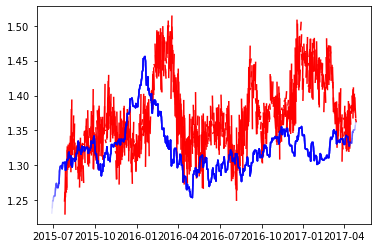

In [153]:
fig, ax = plt.subplots()

for i in range(len(forecasts)):

    fc = forecasts[i]
    gt = test_df.loc[test_df.date.isin(fc.index)]

    ax.plot(fc.index[-2:], fc[-2:], alpha=1.0, color='red')
    ax.plot(gt.date, gt['USD_CLOSE'], alpha=0.1, color='blue')
    

In [157]:
np_baseline_mean_metrics = pd.DataFrame(np_baseline_error_metrics).mean(axis=0).rename('neuralprophet_mean_metrics')
np_baseline_std_metrics = pd.DataFrame(np_baseline_error_metrics).std(axis=0).rename('neuralprophet_std_metrics')
np_baseline_max_metrics = pd.DataFrame(np_baseline_error_metrics).max(axis=0).rename('neuralprophet_max_metrics')

np_baseline_mean_metrics

mse     0.004831
rmse    0.064401
mae     0.057256
mape    0.043291
Name: neuralprophet_mean_metrics, dtype: float64

In [158]:
prophet_mean_metrics

mse     0.004989
rmse    0.062002
mae     0.060038
mape    0.045071
Name: prophet_mean_metrics, dtype: float64

In [161]:
pd.concat((prophet_mean_metrics, np_baseline_mean_metrics), axis=1).T

,mse,rmse,mae,mape
prophet_mean_metrics,0.004989,0.062002,0.060038,0.045071
neuralprophet_mean_metrics,0.004831,0.064401,0.057256,0.043291


### Restricted model

The baseline NeuralProphet model does not perform well on out-of-sample data. We can consider multiple changes to the model's configuration and hyperparameters in pursuit of better performance. Let's consider the following configuration that restricts the model to using only the last observed value of last regressors, as opposed to `n_lags` past observations. While less expressive, this model may be less prone to overfitting.

In [163]:
np_model_last_sample_only = NeuralProphet(n_lags=lag_time, n_forecasts=lead_time)

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('USD_CLOSE', 'ds', 'y')]
for feature in feature_cols:
    np_model_last_sample_only.add_lagged_regressor(f'{feature}', only_last_value=True)
    
np_model_last_sample_only.fit(np_train_df, freq='D')

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 138
INFO:NP.config:Auto-set epochs to 138
 93%|█████████▎| 252/272 [00:04<00:00, 57.19it/s]
INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.58E-03, min: 3.23E-01
INFO:NP.utils_torch:lr-range-test results: steep: 9.58E-03, min: 3.23E-01
 92%|█████████▏| 250/272 [00:04<00:00, 57.05it/s]
INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.30E-02, min: 3.76E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.30E-02, min: 3.76E-01
 92%|█████████▏| 250/272 [00:04<00:00, 56.78it/s]
INFO - (NP.utils_torch.lr_range_test) - lr-range-test resul

,SmoothL1Loss,MAE,RMSE,RegLoss
0,1.947089,0.771257,0.962676,0.0
1,1.773446,0.714278,0.895392,0.0
2,1.583639,0.651742,0.819478,0.0
3,1.382780,0.585392,0.736475,0.0
4,1.199520,0.524499,0.660209,0.0
...,...,...,...,...
133,0.001779,0.013326,0.018895,0.0
134,0.001776,0.013303,0.018864,0.0
135,0.001775,0.013315,0.018832,0.0
136,0.001773,0.013305,0.018860,0.0


In [164]:
forecasts = collect_np_forecasts(np_model_last_sample_only, test_dataset)
np_last_sample_only_error_metrics, fcs = compute_np_error_metrics(forecasts)

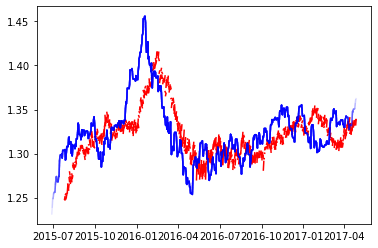

In [165]:
fig, ax = plt.subplots()

for i in range(len(forecasts)):

    fc = forecasts[i]
    gt = test_df.loc[test_df.date.isin(fc.index)]

    ax.plot(fc.index[-2:], fc[-2:], alpha=1.0, color='red')
    ax.plot(gt.date, gt['USD_CLOSE'], alpha=0.1, color='blue')

In [168]:
np_last_sample_only_mean_metrics = pd.DataFrame(np_last_sample_only_error_metrics).mean(axis=0).rename('np_last_sample_only_mean_metrics')
np_last_sample_only_std_metrics = pd.DataFrame(np_last_sample_only_error_metrics).std(axis=0).rename('np_last_sample_only_std_metrics')
np_last_sample_only_max_metrics = pd.DataFrame(np_last_sample_only_error_metrics).max(axis=0).rename('np_last_sample_only_max_metrics')

np_last_sample_only_mean_metrics

mse     0.000589
rmse    0.021876
mae     0.018898
mape    0.014188
Name: np_last_sample_only_mean_metrics, dtype: float64

In [169]:
pd.concat((prophet_mean_metrics, np_baseline_mean_metrics, np_last_sample_only_mean_metrics), axis=1).T

,mse,rmse,mae,mape
prophet_mean_metrics,0.004989,0.062002,0.060038,0.045071
neuralprophet_mean_metrics,0.004831,0.064401,0.057256,0.043291
np_last_sample_only_mean_metrics,0.000589,0.021876,0.018898,0.014188


### Model with Sparse Neural Autoregression

In [23]:
np_model_sparse_nar = NeuralProphet(n_lags=lag_time, 
                                    n_forecasts=lead_time,
                                    learning_rate=1e-2,
                                    num_hidden_layers=1,
                                    d_hidden=16,
                                    ar_sparsity=0.9
                                    )

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('USD_CLOSE', 'ds', 'y')]
for feature in feature_cols:
    np_model_sparse_nar.add_lagged_regressor(f'{feature}')
    
np_model_sparse_nar.fit(np_train_df, freq='D')

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 132
INFO:NP.config:Auto-set epochs to 132
Epoch[132/132]: 100%|██████████| 132/132 [01:11<00:00,  1.83it/s, SmoothL1Loss=0.000685, MAE=0.0113, RMSE=0.0151, RegLoss=0.000137]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,1.825703,0.934001,1.203264,0.000000
1,1.110226,0.632682,0.792531,0.000000
2,0.942576,0.560292,0.697091,0.000000
3,0.863202,0.525289,0.653615,0.000000
4,0.783049,0.490040,0.609291,0.000000
...,...,...,...,...
127,0.000688,0.011321,0.015119,0.000137
128,0.000687,0.011305,0.015089,0.000137
129,0.000686,0.011304,0.015078,0.000137
130,0.000685,0.011292,0.015089,0.000137


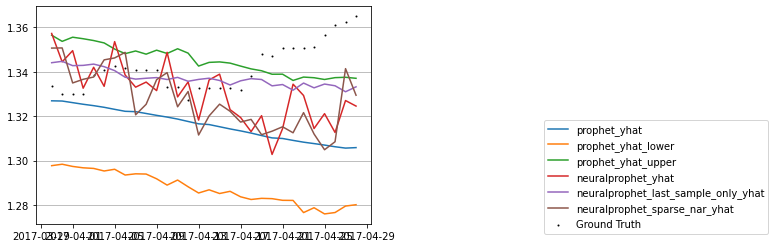

In [24]:
np_future_df_sparse_nar = np_model_sparse_nar.make_future_dataframe(np_test_df.iloc[:lag_time], periods=lead_time)
np_forecast_sparse_nar = np_model_sparse_nar.predict(np_future_df_sparse_nar, decompose=False)
yhat_df, results_df['neuralprophet_sparse_nar_yhat'] = yhat_from_neuralprophet_forecast(np_forecast_sparse_nar, 'neuralprophet_sparse_nar_yhat')
plot_results(results_df)

In [26]:
eval_columns = ['prophet_yhat', 
                'neuralprophet_yhat', 
                'neuralprophet_last_sample_only_yhat',
                'neuralprophet_sparse_nar_yhat',
                ] 
apply_eval_metrics(results_df, eval_columns, metrics)

,mse,rmse,mae,mape
neuralprophet_last_sample_only_yhat,0.000189,0.013761,0.010566,0.007837
neuralprophet_yhat,0.000521,0.022818,0.018338,0.013611
neuralprophet_sparse_nar_yhat,0.000592,0.024330,0.019476,0.014455
prophet_yhat,0.000905,0.030076,0.025326,0.018790


# Reflections and Next Steps

So far, the best performing model on the exchange rates dataset is the baseline, univariate Prophet model. Using this very simple experiment using a single period for out-of-sample forecast evaluation, we have failed to find a configuration of NeuralProphet (which includes other currency values as additional covariates or features) that outperforms the univariate baseline. This reflects a common challenge in forecasting: how to incorporate additional sources of information such that they reliably improve forecasts over univariate baselines?

Of course, we have only considered a very small number of comfigurations using NeuralProphet, many more model and hyperparameter configurations are possible. Please refer to the [NeuralProphet documentation](https://neuralprophet.com/html/contents.html) for detailed information. However, to *find* a better configuration may require significant effort, either manual or automated (via a hyperparameter search, for example). In practical forecasting use cases, it may be important to consider the time, resources, and effort that are needed to find a forecasting model that is better than  baseline.

The following notebooks in this series will cover additional models (N-BEATS and DeepAR) as well as rolling cross validation using Prophet. In order to compare the out-of-sample forecasts produced by this notebook to others, the `results_df` DataFrame is saved below. Hopefully we will find a model that can outperform Prophet in our out-of-sample evaluation experiment!


In [27]:
output_filename = "/content/drive/MyDrive/bootcamp_datasets/exchange_rate/exchange_rate_results_notebook1.csv"
results_df.to_csv(output_filename)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/bootcamp_datasets/exchange_rate/exchange_rate_results_notebook1.csv'